In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os
from tensorflow.keras.models import model_from_json
import scipy.signal
import math as m
from utils.num_separate import lineSegment,preprocess,wordSegment
from utils.nlp_words import answer
from utils.s_extract import check_extraction
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

In [2]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

# Convert 2D to 3D image
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

plt.rcParams['figure.figsize'] = (10.0, 10.0)
def implt(img, cmp=None, t=''):
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

alph="ACDEFGHILMNOPQRSTUVXZ"
dic={}
for i,ch in enumerate(alph):
    dic[i]=ch    

def bilateral_norm(img):
    img = cv2.bilateralFilter(img, 9, 15, 30)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
def histogram_norm(img):
    img = bilateral_norm(img)
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # Filtrage en image dont les pixels de premier plan sont blancs
    img = 255 - img #filtrage en noir 
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255  # normalisation      
    hist, bins = np.histogram(img.ravel(), 256, [0,256]) # img.ravel pour transformer l'image en un vecteur
                                                         #  
    img = img.astype(np.uint8) # 

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)
def cropp(img):
    h,w = img.shape
    top=0
    down=0
    left=0
    right=0
    
    halt = False
    for i in range(h):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                top = i-1
                break
                
    halt = False
    for i in reversed(range(h)):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                down = i+1
                break
    
    halt = False
    for i in range(w):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                left = i-1
                break
                
    halt = False
    for i in reversed(range(w)):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                right = i+1
                break
                
    if (top < 0): top = 0
    if (down < 0): down = 0
    if (left < 0): left = 0
    if (right < 0): right = 0
        
    #print('Top: ', top)
    #print('Down: ', down)
    #print('Left: ', left)
    #print('Right: ', right)
    
    return img[top:down, left:right]
def segment1(img, indexes):
    width=img.shape[1]
    height=img.shape[0]
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    print("svee: ", indexes)
    first = 0
    second = 1
    while (first < len(indexes)) and (second < len(indexes)):
        width = indexes[second] - indexes[first]
        if width <42: # paramètre de réglage
            second += 1
            continue
        roi = img[0:height, indexes[first]:indexes[first]+width]
        roi=cv2.resize(roi,(28,28))
        rois.append(roi)
        first = second
        second += 1
    plt.figure(figsize=(16, 16))
    for i in range(len(rois)):
        ax = plt.subplot(1, len(rois), i+1)
        plt.imshow(rois[i], cmap='binary')
        plt.title(i, fontdict={'fontsize': 15, 'color': 'black'})
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    return rois
        


def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = 255-histogram_norm(img) 
    thresh = cropp(thresh)
    return thresh

def vertical_projection(thresh):
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    hist=sumCols
    hist=(hist - np.amin(hist))/(np.amax(hist) - np.amin(hist))
    return hist # retourne le nombre de pixels blancs de chaque colonne de l'image binarisée


def fix_hist(hist,seuil):
    hist_=[]
    for i in range(len(hist)):
        if hist[i]<=seuil:
            hist_.append(0)
        else:
            b=hist[i]
            hist_.append(b)
    return hist_

def find_indexe(s):
    index=[]
    i=0
    while i<=len(s)-1:
        cnt_0=0
        j=0
        #if i==0 and s[i]==0:
            #index.append(cnt_0)
            #i+=1
            
        if s[i]!=0 and i<=len(s)-1:
            i+=1
        else:
            j=i-1
            while s[i]==0 and i<=len(s)-1:
                if i==len(s)-1:
                    cnt_0+=1
                    i+=1
                    break
                else:
                    cnt_0+=1
                    i+=1
            index.append(m.ceil(cnt_0/2)+j)
                
                
    return index
        

def plot_histogram(thresh,hist,indexes):
    h, w = thresh.shape
    RGBmask = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)+255 # création de fond blanc
    count=0
    for l in hist:
        cv2.line(RGBmask, (count, int(h*(l))), (count, h), color=[0,255,0], thickness=1)
        count += 1

    for i in indexes:
        cv2.circle(RGBmask, (i, int(h*hist[i])), radius=2, color=[255,0,0], thickness=-1) 
        #cv2.line(RGBmask, (i, 0), (i, h), color=[255,0,0],#thickness=1)
    implt(thresh,'gray', 'Binary OTSU + (Filter + TO_ZERO)')
    implt(RGBmask, cmp='gray', t='Final')



import statistics as st
def binary_graph(thresh):
    # Binary graph
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    hist=np.zeros(len(sumCols))
    #mpx=np.maximum(np.min(np.nonzero(sumCols)),30)
    mpx=np.mean(sumCols)
    for pix in range(len(sumCols)):
        if sumCols[pix]>mpx:
            hist[pix]=1
        else:
            hist[pix]=0
    return hist
def binary_index(hist):
    # Find index
    import math as m
    indexes=find_indexe(hist)
    #print('index',ind)
    return indexes

def count_pixel(thresh):
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    return sumCols # retourne le nombre de pixels blancs de chaque colonne de l'image binarisée
def peack_width(indexes):
    W=[]
    for i in range(len(indexes)-1):
        W.append(indexes[i+1]-indexes[i])
    return W   
def segment1(img, indexes):
    pw=int(np.mean(peack_width(indexes)))
    width=img.shape[1]
    height=img.shape[0]
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    first = 0
    second = 1
    while (first < len(indexes)) and (second < len(indexes)):
        width = indexes[second] - indexes[first]
        if width <=pw and second!=len(indexes)-1: # paramètre de réglage
            second += 1
            continue
        roi = img[0:height, indexes[first]:indexes[first]+width]
        rois.append(roi)
        first = second
        second += 1
    for i in range(len(rois)):
        if rois[i].shape[1]>10:
            rois[i]=cv2.resize(rois[i],(28,28))
    return rois 
def clear(img):
    clean=preprocessing(img)
    cv2.imwrite('clean.png',clean)
    clean=cv2.imread("clean.png")
    plt.imshow(clean,'gray')
    return clean

In [3]:
model=load_model(r'models\model.h5', custom_objects={"custom_metric": custom_f1score}, compile=False)

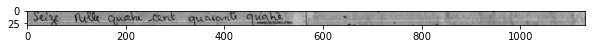

In [144]:
img=cv2.imread(r"C:/Users/Obertys/Desktop/OCR_cheques/cheques/cheque2.jpg")
img1=check_extraction(img)[1] 
img2=check_extraction(img)[2]
img2=cv2.resize(img2,(img1.shape[1],img1.shape[0]))
vis = np.concatenate((img1, img2), axis = 1)
cv2.imwrite('mont.png',vis)
#im=delete_line(im) #zone 0:mtc, 1:mtl1, 2:mtl2, 3:date, 4:nom, 5:sign, 6:lieu
implt(vis)

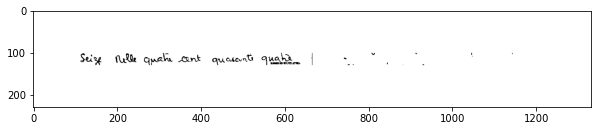

In [145]:

img=preprocess('mont.png')
#img=clear(vis)

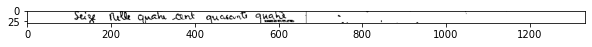

No. of Lines 1
48964.0
48939.0
53051.5
39306.0
67257.0
81046.0
10454.0
5002.5
4014.0
4386.5
3326.0
1226.0
2472.5
2183.0
4424.5
2072.5
mean of area= 1226.0
No. of Words 6


In [146]:
#img=clear(im)
textLines=lineSegment(img)

words=wordSegment(textLines)


In [147]:
def segmentChar(word):
    thresh=preprocessing(word)
    b=binary_graph(thresh)
    f=binary_index(b)
    s=segment1(thresh,f)
    return s

In [148]:
def recognition(chars):
    words=[]
    for char in chars:
        if char.shape==(28,28):
            img=fix_dimension(char)
            new=img.reshape(1,28,28,3)
            pred=model.predict_classes(new)[0]
            words.append(dic[pred])
    word="".join(words)
    return answer(word)

In [149]:
def rMont(words):
    for word in words:
        chars=segmentChar(word)
        w=recognition(chars)
        if w!=None:
            print(w,end=' ')
            if w=="FRANCS" or w=="FRANC":
                break

In [150]:
rMont(words)

SEIZE MILLE QUATRE CENT QUARANTE QUATRE 